# VGGNet Model Implementation - CIFAR-10
---

In [1]:
%matplotlib inline
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn
from collections import defaultdict
from matplotlib import pyplot as plt

import torch
import numpy as np

# Dataset and DataLoader

In [2]:
cifar10_dataset = datasets.CIFAR10(
    root='../dataset/CIFAR-10',
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

imgs = [img for img, _ in cifar10_dataset]
imgs = torch.stack(imgs, dim=0).numpy()

cifar10_means = [
    imgs[:, 0, :, :].mean(),
    imgs[:, 1, :, :].mean(),
    imgs[:, 2, :, :].mean(),
]
cifar10_stds = [
    imgs[:, 0, :, :].std(),
    imgs[:, 1, :, :].std(),
    imgs[:, 2, :, :].std(),
]

print(imgs.shape)
print(cifar10_means, cifar10_stds)

Files already downloaded and verified
(50000, 3, 32, 32)
[0.49139968, 0.48215827, 0.44653124] [0.24703233, 0.24348505, 0.26158768]


In [3]:
img_transforms = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar10_means, std=cifar10_stds),
])

train_dataset = datasets.CIFAR10(
    root='../dataset/CIFAR-10',
    train=True,
    download=True,
    transform=img_transforms,
)

test_dataset = datasets.CIFAR10(
    root='../dataset/CIFAR-10',
    train=False,
    download=True,
    transform=img_transforms,
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Model
---
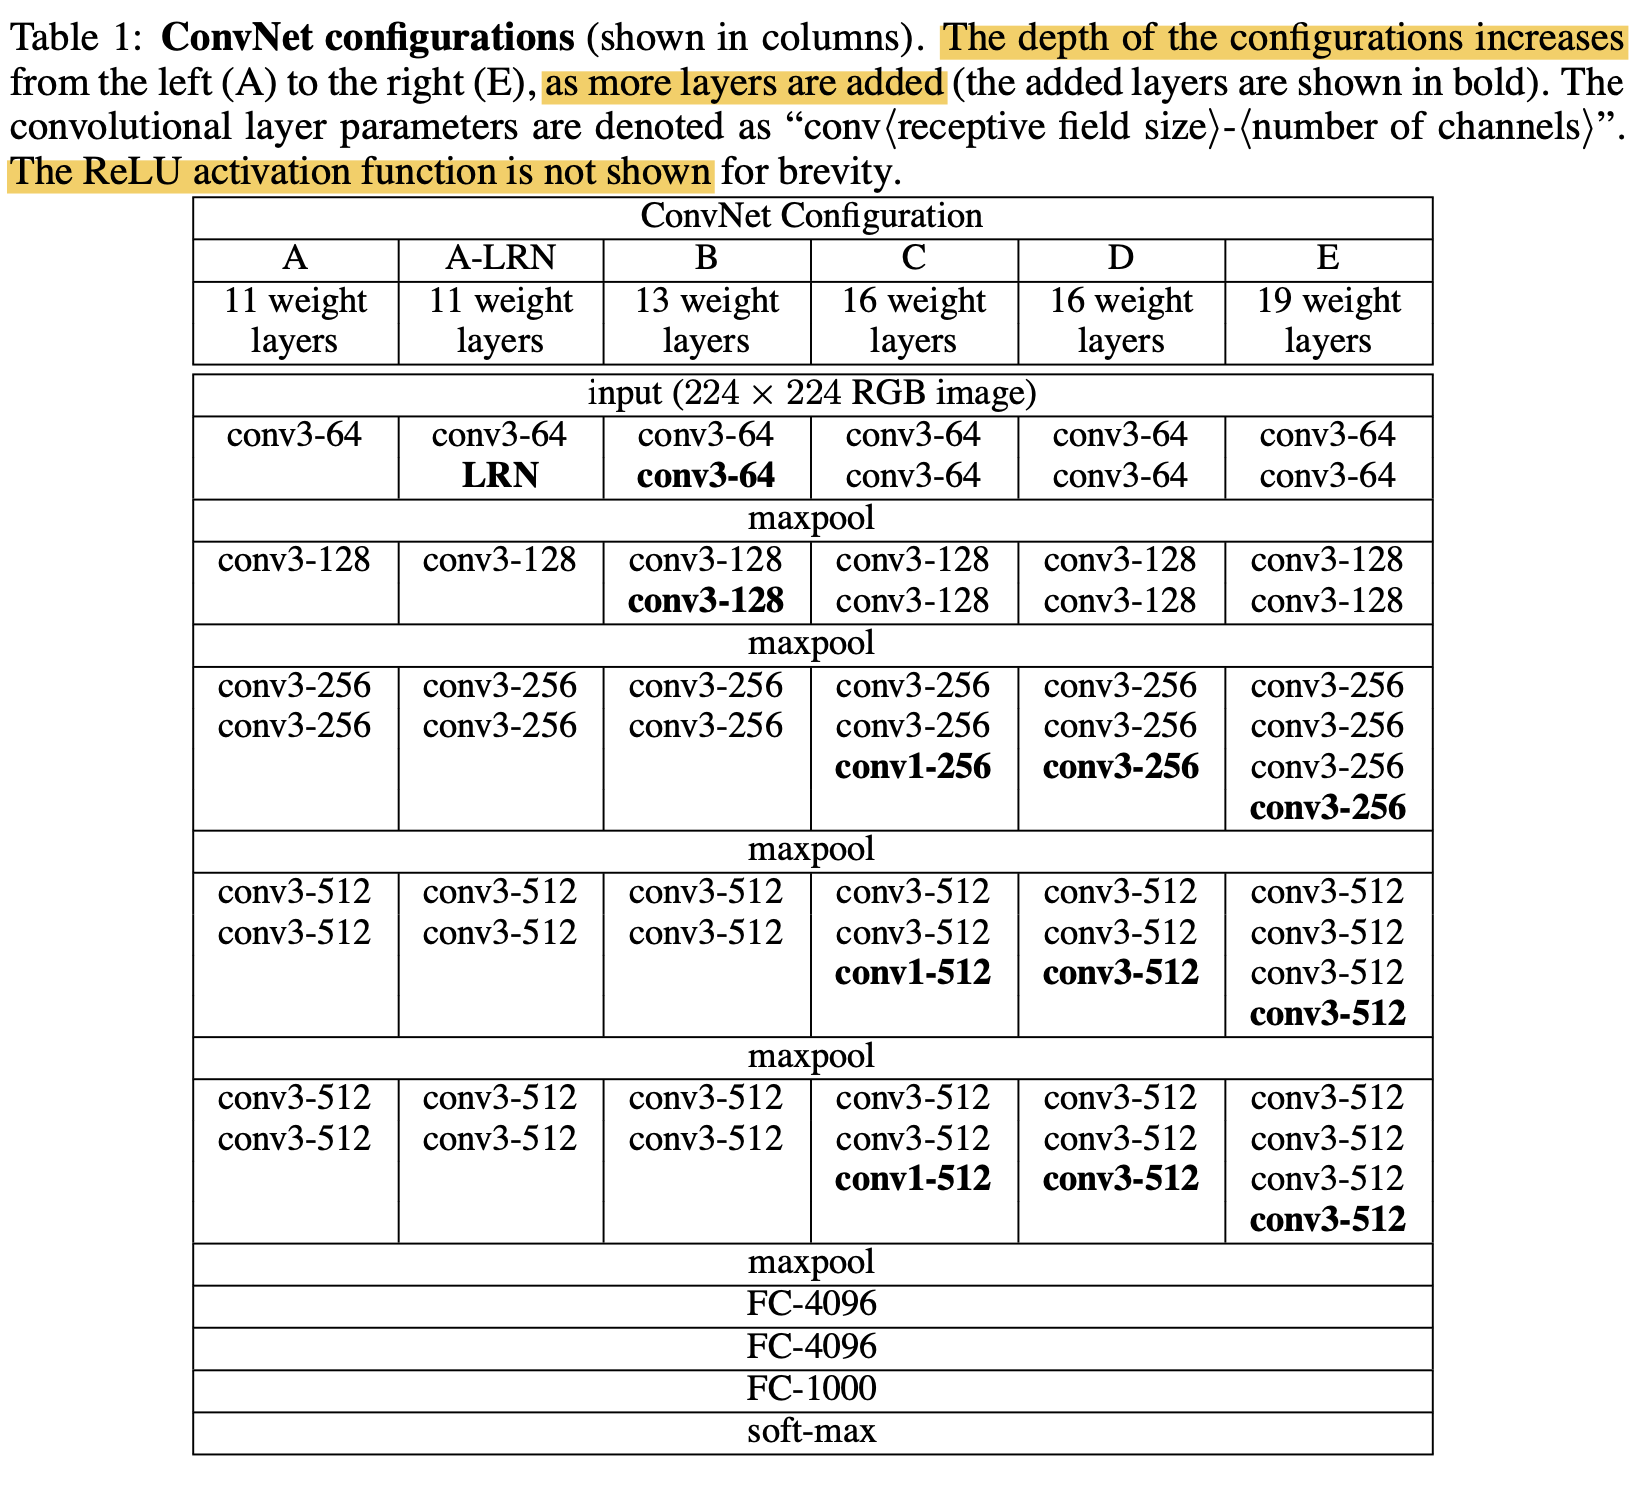

In [5]:
class VGG(nn.Module):
    cfg = {
        16: [
            64, 64, "M",
            128, 128, "M",
            256, 256, 256, "M",
            512, 512, 512, "M",
            512, 512, 512, "M",
        ],
        19: [
            64, 64, "M",
            128, 128, "M",
            256, 256, 256, 256, "M", 
            512, 512, 512, 512, "M",
            512, 512, 512, 512, "M",
        ],
    }
    
    def __init__(self, num_layers=16, num_cls=10, dropout_rate=0.5):
        super(VGG, self).__init__()
        self.num_layers = num_layers
        self.num_cls = num_cls
        self.features = self.make_layers(VGG.cfg[self.num_layers])
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(1*1*512, 4096),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(4096, self.num_cls),
        )
        
        # Weight Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
    def make_layers(self, cfg):
        layers = []
        in_channels = 3
        for l_type in cfg:
            if l_type != "M":
                out_channels = int(l_type)
                conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
                layers += [
                    conv2d, 
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(),
                ]
                in_channels = out_channels
            else:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

## VGG-16

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_layers = 16
model = VGG(num_layers=num_layers).to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

## VGG-19

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_layers = 19
model = VGG(num_layers=num_layers).to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

# Training and Test
---
## Loss Function, Optimizer, and Scheduler

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
    momentum=0.9,
    weight_decay=5e-4
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=15,
    gamma=0.1
)

## Training Function

In [14]:
def train(dataloader, model, loss_fn, optimizer, scheduler, device):
    total_nums = len(dataloader.dataset)
    model.train()
    
    losses = []
    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        
        preds = model(images)
        loss = loss_fn(preds, labels)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, cur_nums = loss.item(), batch * len(images)
            print(f'loss: {loss:>7f} [{cur_nums:>5d}/{total_nums:>5d}]')
        
        # Scheduler Location : https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
    scheduler.step()
        
    return sum(losses)/len(losses)

## Test Function

In [15]:
def test(dataloader, model, loss_fn, device):
    total_nums = len(dataloader.dataset)
    batch_nums = len(dataloader)
    model.eval()
    test_loss, corrects = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            test_loss += loss_fn(preds, labels).item()
            corrects += (preds.argmax(1) == labels).type(torch.float).sum().item()

        test_loss /= batch_nums
        acc = corrects / total_nums * 100
        print(f'Test Error:\n Accuracy: {acc:>0.1f}%, Avg Loss: {test_loss:>8f}\n')
    return test_loss, acc

## Training and Test (VGG-16)

In [10]:
epochs, results = 50, defaultdict(list)
for epoch in range(epochs):
    print(f'Epoch {epoch+1}:')
    print('-' * 30)
    train_loss = train(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    test_loss, test_acc = test(test_dataloader, model, loss_fn, device)
    results['train_loss'].append(train_loss)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)
    
print('Done.')

Epoch 1:
------------------------------
loss: 2.300221 [    0/50000]
loss: 1.738568 [ 6400/50000]
loss: 1.332877 [12800/50000]
loss: 1.514238 [19200/50000]
loss: 1.196505 [25600/50000]
loss: 1.469705 [32000/50000]
loss: 1.082048 [38400/50000]
loss: 1.152867 [44800/50000]
Test Error:
 Accuracy: 60.8%, Avg Loss: 1.142147

Epoch 2:
------------------------------
loss: 1.152451 [    0/50000]
loss: 0.932431 [ 6400/50000]
loss: 0.775235 [12800/50000]
loss: 0.921600 [19200/50000]
loss: 0.867385 [25600/50000]
loss: 1.132944 [32000/50000]
loss: 0.875299 [38400/50000]
loss: 0.880509 [44800/50000]
Test Error:
 Accuracy: 73.0%, Avg Loss: 0.782208

Epoch 3:
------------------------------
loss: 0.800065 [    0/50000]
loss: 0.758696 [ 6400/50000]
loss: 0.618895 [12800/50000]
loss: 0.740750 [19200/50000]
loss: 0.731443 [25600/50000]
loss: 0.900201 [32000/50000]
loss: 0.747492 [38400/50000]
loss: 0.841016 [44800/50000]
Test Error:
 Accuracy: 77.9%, Avg Loss: 0.670772

Epoch 4:
-------------------------

## Training and Test (VGG-19)

In [16]:
epochs, results = 50, defaultdict(list)
for epoch in range(epochs):
    print(f'Epoch {epoch+1}:')
    print('-' * 30)
    train_loss = train(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    test_loss, test_acc = test(test_dataloader, model, loss_fn, device)
    results['train_loss'].append(train_loss)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)
    
print('Done.')

Epoch 1:
------------------------------
loss: 2.298691 [    0/50000]
loss: 1.857327 [ 6400/50000]
loss: 1.437183 [12800/50000]
loss: 1.552870 [19200/50000]
loss: 1.423867 [25600/50000]
loss: 1.423244 [32000/50000]
loss: 1.300025 [38400/50000]
loss: 1.102789 [44800/50000]
Test Error:
 Accuracy: 57.7%, Avg Loss: 1.193048

Epoch 2:
------------------------------
loss: 1.164783 [    0/50000]
loss: 1.018938 [ 6400/50000]
loss: 0.897525 [12800/50000]
loss: 1.131110 [19200/50000]
loss: 0.968830 [25600/50000]
loss: 1.155087 [32000/50000]
loss: 0.980812 [38400/50000]
loss: 1.066819 [44800/50000]
Test Error:
 Accuracy: 72.4%, Avg Loss: 0.817600

Epoch 3:
------------------------------
loss: 0.810247 [    0/50000]
loss: 0.762576 [ 6400/50000]
loss: 0.627471 [12800/50000]
loss: 0.863087 [19200/50000]
loss: 0.956456 [25600/50000]
loss: 0.880792 [32000/50000]
loss: 0.691174 [38400/50000]
loss: 0.743633 [44800/50000]
Test Error:
 Accuracy: 72.2%, Avg Loss: 0.842144

Epoch 4:
-------------------------

# Visualization
---
## VGG-16

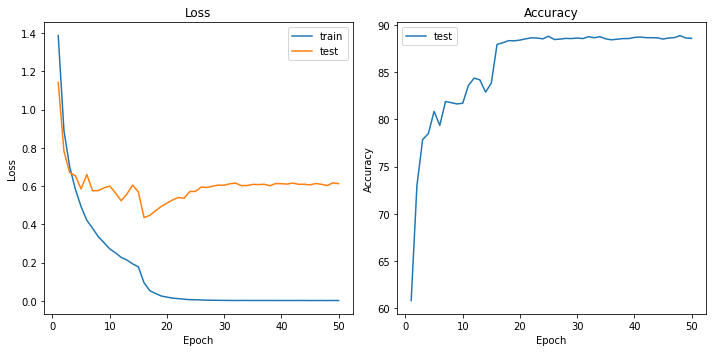

In [11]:
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
epoch_nums = range(1, epochs+1)

axis[0].plot(epoch_nums, results['train_loss'])
axis[0].plot(epoch_nums, results['test_loss'])
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')
axis[0].set_title('Loss')
axis[0].legend(['train', 'test'])

axis[1].plot(epoch_nums, results['test_acc'])
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
axis[1].set_title('Accuracy')
axis[1].legend(['test'])

plt.tight_layout()
plt.show()

## VGG-19

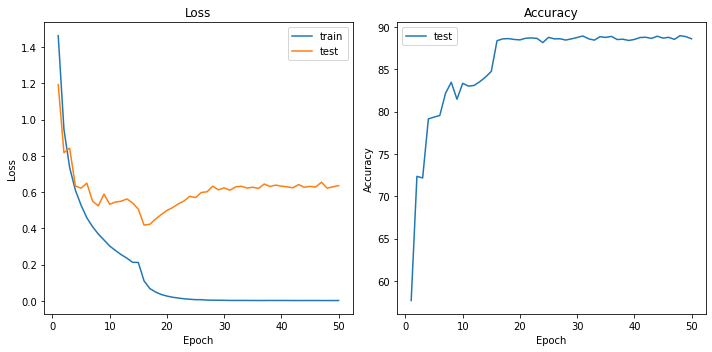

In [17]:
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
epoch_nums = range(1, epochs+1)

axis[0].plot(epoch_nums, results['train_loss'])
axis[0].plot(epoch_nums, results['test_loss'])
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')
axis[0].set_title('Loss')
axis[0].legend(['train', 'test'])

axis[1].plot(epoch_nums, results['test_acc'])
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
axis[1].set_title('Accuracy')
axis[1].legend(['test'])

plt.tight_layout()
plt.show()

# 회고
---
- VGG-16, VGG-19 모두 CIFAR-10에서는 성능이 비슷함. 
- CIFAR-10과 같이 작은 dataset에서는 두 모델의 성능 차이를 보기 힘들 것으로 생각됨. 

# Reference
---
- https://stackoverflow.com/a/68123869
- https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
- https://www.geeksforgeeks.org/plot-multiple-plots-in-matplotlib/